# Roll Motion Forecasting using ARIMA and Neural Network

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (12,8)
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Dataset

In [2]:
roll = pd.read_csv('roll.csv')
roll_test = pd.read_csv('roll_test.csv')

## ARIMA Model

ARIMA = Autoregressive Integrated Moving Averange 

In [3]:
roll.head()

,Y
0,0.2083
1,0.1920
2,0.1759
3,0.1589
4,0.1410


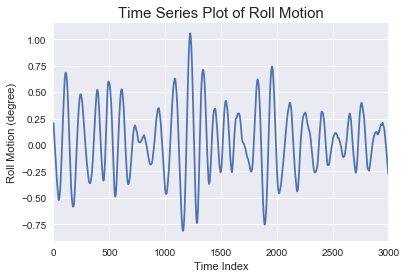

In [4]:
sns.tsplot(roll['Y'])
plt.title('Time Series Plot of Roll Motion', size=15)
plt.xlabel('Time Index')
plt.ylabel('Roll Motion (degree)')
plt.show()

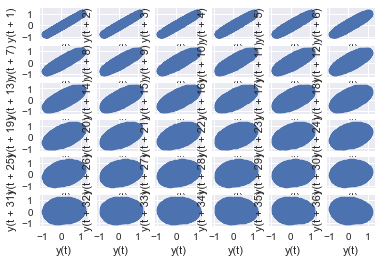

In [5]:
fig, axes = plt.subplots(nrows=6, ncols=6, sharex=True, sharey=True)
lag_index = 1
for i in range(6):
    for j in range(6):
        pd.plotting.lag_plot(roll['Y'], lag=lag_index, ax=axes[i,j])
        lag_index += 1
plt.show()

## ACF & PACF

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

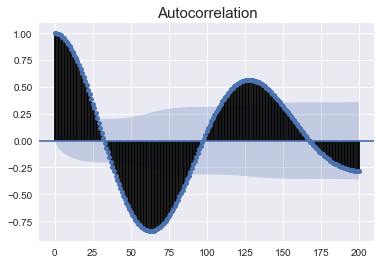

In [7]:
plot_acf(roll['Y'], lags=200)
plt.title('Autocorrelation', size=15)
plt.show()

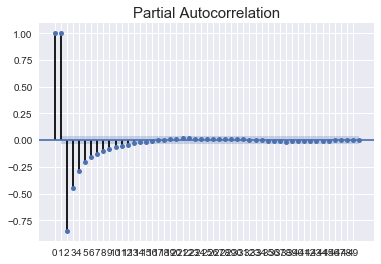

In [8]:
plot_pacf(roll['Y'], lags = 50)
plt.title('Partial Autocorrelation', size=15)
plt.xticks(range(0,50))
plt.show()

## ARIMA Model

Model: ARIMA([1,2,3,4,9,19,20],0,[19])

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [10]:
model = SARIMAX(np.array(roll[['Y']]), order=((1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1),0,
                                              (0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1)))

In [11]:
res = model.fit(disp=False)
print(res.summary())

                                       Statespace Model Results                                       
Dep. Variable:                                              y   No. Observations:                 3000
Model:             SARIMAX((1, 2, 3, 4, 9, 19, 20), 0, (19,))   Log Likelihood               17265.523
Date:                                        Sat, 10 Mar 2018   AIC                         -34513.047
Time:                                                07:58:52   BIC                         -34458.990
Sample:                                                     0   HQIC                        -34493.603
                                                       - 3000                                         
Covariance Type:                                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.4

In [12]:
ARIMAforecast = res.forecast(250)
ARIMAresid = pd.DataFrame(res.resid)

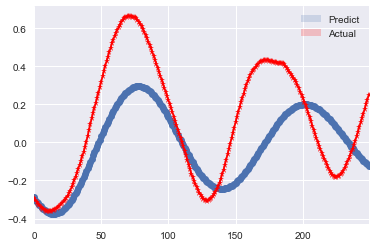

In [13]:
sns.tsplot(ARIMAforecast, marker='o')
sns.tsplot(roll_test['Y'], marker='*', color='r')
plt.legend(['Predict', 'Actual'])
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error

In [15]:
print ('RMSE = '+ str(mean_squared_error(roll_test['Y'], ARIMAforecast)**0.5))

RMSE = 0.24085392458936355


## Neural Network

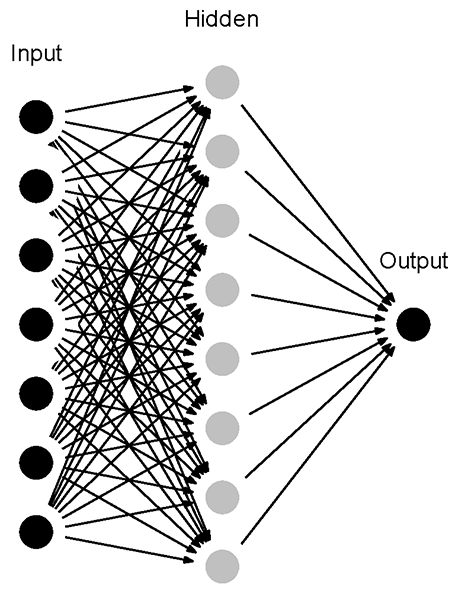

In [16]:
from IPython.display import Image
fig = Image(filename=('supports/architecture.png'))
fig

In [17]:
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.tsatools import lagmat

In [18]:
train = lagmat(roll['Y'], 20, trim='both', original='in', use_pandas=True)

In [19]:
train.head()

,Y,Y.L.1,Y.L.2,Y.L.3,Y.L.4,Y.L.5,Y.L.6,Y.L.7,Y.L.8,Y.L.9,...,Y.L.11,Y.L.12,Y.L.13,Y.L.14,Y.L.15,Y.L.16,Y.L.17,Y.L.18,Y.L.19,Y.L.20
20,-0.1438,-0.1245,-0.1067,-0.0902,-0.0759,-0.0623,-0.0482,-0.0326,-0.0152,0.0041,...,0.0455,0.0661,0.0861,0.1052,0.1230,0.1410,0.1589,0.1759,0.1920,0.2083
21,-0.1634,-0.1438,-0.1245,-0.1067,-0.0902,-0.0759,-0.0623,-0.0482,-0.0326,-0.0152,...,0.0247,0.0455,0.0661,0.0861,0.1052,0.1230,0.1410,0.1589,0.1759,0.1920
22,-0.1816,-0.1634,-0.1438,-0.1245,-0.1067,-0.0902,-0.0759,-0.0623,-0.0482,-0.0326,...,0.0041,0.0247,0.0455,0.0661,0.0861,0.1052,0.1230,0.1410,0.1589,0.1759
23,-0.1981,-0.1816,-0.1634,-0.1438,-0.1245,-0.1067,-0.0902,-0.0759,-0.0623,-0.0482,...,-0.0152,0.0041,0.0247,0.0455,0.0661,0.0861,0.1052,0.1230,0.1410,0.1589
24,-0.2141,-0.1981,-0.1816,-0.1634,-0.1438,-0.1245,-0.1067,-0.0902,-0.0759,-0.0623,...,-0.0326,-0.0152,0.0041,0.0247,0.0455,0.0661,0.0861,0.1052,0.1230,0.1410


In [20]:
Y_train = np.array(train['Y']).reshape(-1, 1)
X_train = train[['Y.L.1', 'Y.L.2', 'Y.L.3', 'Y.L.4', 'Y.L.9', 'Y.L.19', 'Y.L.20']]

In [21]:
def NNForecast(hidden_layer, activation):
    NN = MLPRegressor(hidden_layer_sizes=(hidden_layer,), activation=activation, random_state=123)
    NN.fit(X_train, Y_train)
    for i in range(3000,3250):
        roll.loc[i, 'Y'] = NN.predict(np.array([roll.loc[i-1,'Y'], roll.loc[i-2,'Y'], roll.loc[i-3,'Y'], 
                roll.loc[i-4,'Y'], roll.loc[i-9,'Y'], roll.loc[i-19,'Y'], roll.loc[i-20,'Y']]).reshape(1,-1))
    mse = mean_squared_error(roll_test['Y'], roll.loc[3000:3250,'Y'])
    return (mse**0.5)

In [22]:
def ModelSelection(nodes, activation):
    RMSE = [0]*nodes
    for j in range(nodes):
        RMSE[j] = NNForecast(j+1, activation)
    return {'RMSE':RMSE, 'best':np.argmin(RMSE), 'minRMSE':np.min(RMSE)}

In [23]:
resultNN = ModelSelection(200, 'relu')

In [24]:
resultNN['best']

145

In [25]:
resultNN['minRMSE']

0.14984993332689636

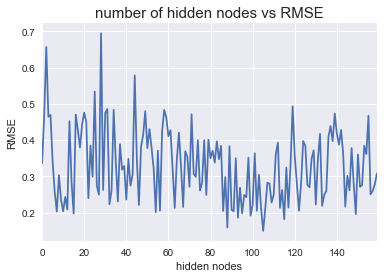

In [26]:
sns.tsplot(resultNN['RMSE'][40:])
plt.title('number of hidden nodes vs RMSE', size=15)
plt.xlabel('hidden nodes')
plt.ylabel('RMSE')
plt.show()

## Apply the best NN model

In [27]:
NN = MLPRegressor(hidden_layer_sizes=(146,), activation='relu', random_state=123)
NN.fit(X_train, Y_train)
for i in range(3000,3250):
    roll.loc[i, 'Y'] = NN.predict(np.array([roll.loc[i-1,'Y'], roll.loc[i-2,'Y'], roll.loc[i-3,'Y'], 
        roll.loc[i-4,'Y'], roll.loc[i-9,'Y'], roll.loc[i-19,'Y'], roll.loc[i-20,'Y']]).reshape(1,-1))

In [28]:
mean_squared_error(roll_test['Y'], roll.loc[3000:3250,'Y'])**0.5

0.14984993332689636

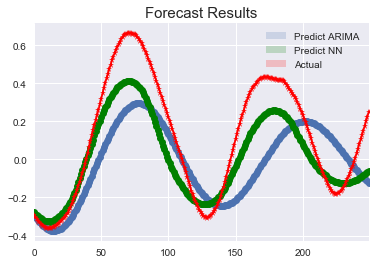

In [29]:
sns.tsplot(ARIMAforecast, marker='o')
sns.tsplot(roll.loc[3000:3250,'Y'], marker='o', color='g')
sns.tsplot(roll_test['Y'], marker='*', color='r')
plt.legend(['Predict ARIMA', 'Predict NN', 'Actual'])
plt.title('Forecast Results', size=15)
plt.show()